In [7]:
'''
Env: Python 3.9
Reads from: Data Depot, ERA5-Interim
Output: 6hour slicing of u, t, v files needed in hn2016-falwa
'''

import os
import datetime as dt
import xarray as xr
from multiprocessing import Pool, cpu_count
from tqdm.notebook import tqdm  

def process_file(args):
    base_dir, output_dir, file = args
    
    year, season, data_type = file.split('_')
    year = int(year.split('-')[0])

    seasons_dates = {
        '01-03': (dt.datetime(year, 1, 1), dt.datetime(year, 3, 31)),
        '04-06': (dt.datetime(year, 4, 1), dt.datetime(year, 6, 30)),
        '07-09': (dt.datetime(year, 7, 1), dt.datetime(year, 9, 30)),
        '10-12': (dt.datetime(year, 10, 1), dt.datetime(year, 12, 31))
    }
    
    start_date, end_date = seasons_dates[season]
    
    ds = xr.open_dataset(os.path.join(base_dir, file))
    
    current_date = start_date
    while current_date <= end_date:
        end_of_6h_date = current_date + dt.timedelta(hours=6)
        if end_of_6h_date > end_date:
            end_of_6h_date = end_date

        subset = ds.sel(time=slice(current_date, end_of_6h_date))
        output_filename = f"{year}_{current_date.strftime('%Y_%m_%d_%H_00')}_{data_type.split('.')[0]}.nc"
        output_filepath = os.path.join(output_dir, output_filename)

        subset.to_netcdf(output_filepath)
        
        next_date = current_date + dt.timedelta(hours=6)
        if next_date > end_date:
            break
        current_date = next_date

    ds.close()

# Main code block
base_dir = "/depot/eapsdept/data/ERA_Interim"
output_dir = "/scratch/negishi/yan481/KenYan_Traffic_Model/Interim_Slice_6hr"

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# List and filter files
all_files = [f for f in os.listdir(base_dir) if f.endswith('.nc')]
valid_files = [f for f in all_files if 1979 <= int(f.split("_")[0].split('-')[0]) <= 2016 and f.split('_')[2] in ['u.nc', 'v.nc', 't.nc']]

# Process files in parallel with tqdm progress bar
with tqdm(total=len(valid_files), desc="Processing files") as pbar:
    def update(*a):
        pbar.update()
    pool = Pool(cpu_count())
    for _ in pool.imap_unordered(process_file, [(base_dir, output_dir, file) for file in valid_files]):
        update()
    pool.close()
    pool.join()


Processing files:   0%|          | 0/456 [00:00<?, ?it/s]

In [1]:
# 20240421 update: add the missed 12-31-06, 12-31-12, 12-31-18 slices to additonal folder

import os
import datetime as dt
import xarray as xr
from multiprocessing import Pool, cpu_count
from tqdm.notebook import tqdm

def process_file(args):
    base_dir, output_dir, file = args
    
    year, season, data_type = file.split('_')
    year = int(year.split('-')[0])

    if season != '10-12':
        return  # Only process files from the October-December season

    start_date, end_date = (dt.datetime(year, 10, 1), dt.datetime(year, 12, 31))
    
    ds = xr.open_dataset(os.path.join(base_dir, file))
    
    # Specific dates and times to process
    target_times = [dt.datetime(year, 12, 31, 6, 0), dt.datetime(year, 12, 31, 12, 0), dt.datetime(year, 12, 31, 18, 0)]
    for current_date in target_times:
        end_of_6h_date = current_date + dt.timedelta(hours=6)
        
        subset = ds.sel(time=slice(current_date, end_of_6h_date))
        output_filename = f"{year}_{current_date.strftime('%Y_%m_%d_%H_00')}_{data_type.split('.')[0]}.nc"
        output_filepath = os.path.join(output_dir, output_filename)

        subset.to_netcdf(output_filepath)

    ds.close()

# Main code block
base_dir = "/depot/eapsdept/data/ERA_Interim"
output_dir = "/scratch/negishi/yan481/KenYan_Traffic_Model/Interim_Slice_6hr_0421supp"

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# List and filter files
all_files = [f for f in os.listdir(base_dir) if f.endswith('.nc')]
valid_files = [f for f in all_files if 1979 <= int(f.split("_")[0].split('-')[0]) <= 2016 and f.split('_')[2] in ['u.nc', 'v.nc', 't.nc']]

# Process files in parallel with tqdm progress bar
with tqdm(total=len(valid_files), desc="Processing files") as pbar:
    def update(*a):
        pbar.update()
    pool = Pool(cpu_count())
    for _ in pool.imap_unordered(process_file, [(base_dir, output_dir, file) for file in valid_files if '10-12' in file]):
        update()
    pool.close()
    pool.join()


Processing files:   0%|          | 0/456 [00:00<?, ?it/s]

In [8]:
import os
import random
import xarray as xr

output_dir = "/scratch/negishi/yan481/KenYan_Traffic_Model/Interim_Slice_6hr"

# obtain all u, v, t files
u_files = [f for f in os.listdir(output_dir) if f.endswith('_u.nc')]
v_files = [f for f in os.listdir(output_dir) if f.endswith('_v.nc')]
t_files = [f for f in os.listdir(output_dir) if f.endswith('_t.nc')]

# random selection to print out info after slicing
random_u_file = random.choice(u_files)
random_v_file = random.choice(v_files)
random_t_file = random.choice(t_files)

# use xarray to read and print
for f in [random_u_file, random_v_file, random_t_file]:
    ds = xr.open_dataset(os.path.join(output_dir, f))
    print(ds)  
    ds.close()


<xarray.Dataset>
Dimensions:    (longitude: 240, latitude: 121, levelist: 37, time: 2)
Coordinates:
  * longitude  (longitude) float32 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
  * latitude   (latitude) float32 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * levelist   (levelist) int32 1 2 3 5 7 10 20 ... 850 875 900 925 950 975 1000
  * time       (time) datetime64[ns] 2009-07-01T18:00:00 2009-07-02
Data variables:
    u          (time, levelist, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.0
    history:      2012-09-24 20:34:48 GMT by mars2netcdf-0.92
<xarray.Dataset>
Dimensions:    (longitude: 240, latitude: 121, levelist: 37, time: 2)
Coordinates:
  * longitude  (longitude) float32 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
  * latitude   (latitude) float32 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * levelist   (levelist) int32 1 2 3 5 7 10 20 ... 850 875 900 925 950 975 1000
  * time       (time) datetime64[ns] 1998-01-11T12:00:00 1998-01-11T18:00:00
Dat

In [6]:
import os
import xarray as xr

# randomly choose one .nc file
output_dir = "/scratch/negishi/yan481/KenYan_Traffic_Model/Interim_Slice2"
u_files = [f for f in os.listdir(output_dir) if f.endswith('_u.nc')]
random_u_file = random.choice(u_files)

ds = xr.open_dataset(os.path.join(output_dir, random_u_file))

# print out all level values
print(ds['levelist'].values)

ds.close()


[   1    2    3    5    7   10   20   30   50   70  100  125  150  175
  200  225  250  300  350  400  450  500  550  600  650  700  750  775
  800  825  850  875  900  925  950  975 1000]


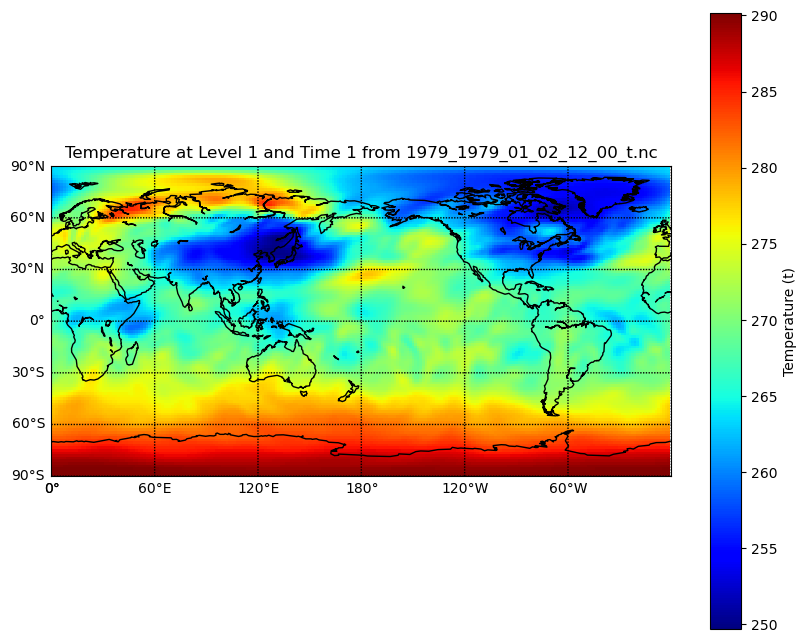

In [4]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap

output_dir = "/scratch/negishi/yan481/KenYan_Traffic_Model/Interim_Slice_6hr"
file_name = '1979_1979_01_02_12_00_t.nc'
file_path = os.path.join(output_dir, file_name)

# Open the dataset using xarray
ds = xr.open_dataset(file_path)

# Selecting the temperature data for the first level and first time instant
t_data = ds['t'][0, 0, :, :]

# Create a larger figure
plt.figure(figsize=(10, 8))  # Adjust the width and height as needed

# Setting up the Basemap projection
m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360)
m.drawcoastlines()
m.drawparallels(range(-90, 91, 30), labels=[1, 0, 0, 0])
m.drawmeridians(range(0, 361, 60), labels=[0, 0, 0, 1])

# Creating the heatmap with specified color range
lon, lat = np.meshgrid(ds['longitude'].values, ds['latitude'].values)
m.pcolormesh(lon, lat, t_data, shading='auto', latlon=True, cmap='jet')
plt.colorbar(label='Temperature (t)')

plt.title('Temperature at Level 1 and Time 1 from 1979_1979_01_02_12_00_t.nc')
plt.show()

ds.close()


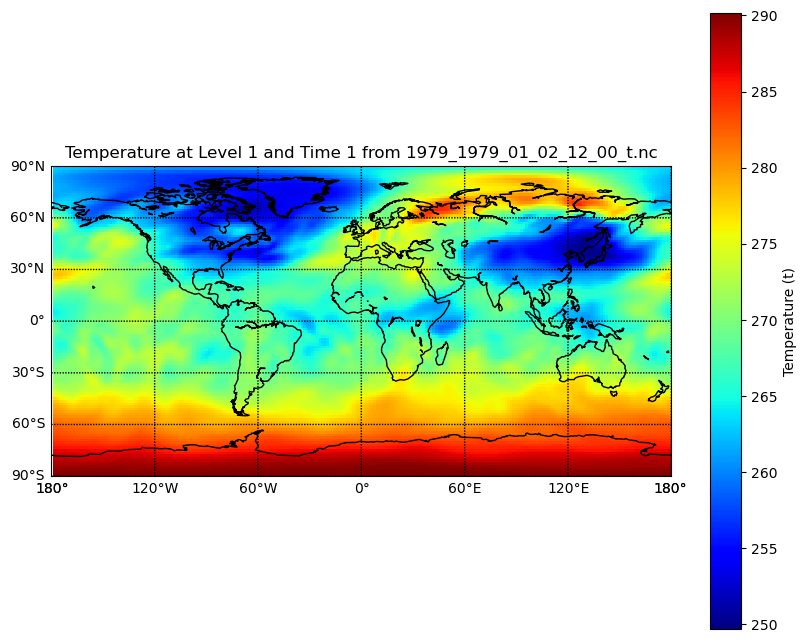

In [6]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap

output_dir = "/scratch/negishi/yan481/KenYan_Traffic_Model/Interim_Slice_6hr"
file_name = '1979_1979_01_02_12_00_t.nc'
file_path = os.path.join(output_dir, file_name)

# Open the dataset using xarray
ds = xr.open_dataset(file_path)

# Selecting the temperature data for the first level and first time instant
t_data = ds['t'][0, 0, :, :].values

# Adjusting longitude values from 0-360 to -180 to 180 and adjusting data accordingly
lon = ds['longitude'].values
lon[lon > 180] -= 360

# Sorting adjusted longitudes and data
sorted_indices = np.argsort(lon)
lon = lon[sorted_indices]
t_data = t_data[:, sorted_indices]

# Create a larger figure
plt.figure(figsize=(10, 8))  # Adjust the width and height as needed

# Setting up the Basemap projection
m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180)
m.drawcoastlines()
m.drawparallels(range(-90, 91, 30), labels=[1, 0, 0, 0])
m.drawmeridians(range(-180, 181, 60), labels=[0, 0, 0, 1])

# Creating the heatmap with specified color range
lat = ds['latitude'].values
lon, lat = np.meshgrid(lon, lat)
m.pcolormesh(lon, lat, t_data, shading='auto', latlon=True, cmap='jet')
plt.colorbar(label='Temperature (t)')

plt.title('Temperature at Level 1 and Time 1 from 1979_1979_01_02_12_00_t.nc')
plt.show()

ds.close()


In [2]:
import xarray as xr

# Load the .nc file using xarray
filename = "/scratch/negishi/yan481/KenYan_Traffic_Model/Interim_Slice_6hr/1979_1979_01_01_06_00_u.nc"
ds = xr.open_dataset(filename)

# Print the dataset's information
print(ds)

# Close the dataset
ds.close()


<xarray.Dataset>
Dimensions:    (longitude: 240, latitude: 121, levelist: 37, time: 2)
Coordinates:
  * longitude  (longitude) float32 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
  * latitude   (latitude) float32 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * levelist   (levelist) int32 1 2 3 5 7 10 20 ... 850 875 900 925 950 975 1000
  * time       (time) datetime64[ns] 1979-01-01T06:00:00 1979-01-01T12:00:00
Data variables:
    u          (time, levelist, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.0
    history:      2012-05-14 19:57:43 GMT by mars2netcdf-0.92
